###Practical Machine Learning and Deep Learning


# Text classification 



In this notebook we will learn how to do  a text classification using LSTM's. We will use the **US Consumer Finance Complaints**. The dataset is not that clean and that's why we must clean the data and make important precessing steps before feeding it to the model. 

We will follow this pipeline : 

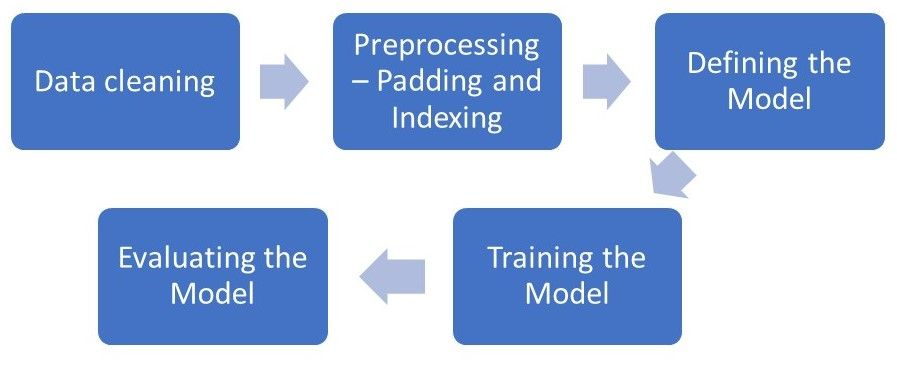

Dataset link : https://www.kaggle.com/datasets/kaggle/us-consumer-finance-complaints

In [13]:
# Loading the dataset in google colab and unzipping it
!unzip '/content/consumer_complaints.csv.zip'

Archive:  /content/consumer_complaints.csv.zip
  inflating: consumer_complaints.csv  


In [14]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Read data

In [15]:
df = pd.read_csv('consumer_complaints.csv')
df = df[['product','consumer_complaint_narrative']]
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,product,consumer_complaint_narrative
0,Mortgage,NaN
1,Mortgage,NaN
2,Credit reporting,NaN
3,Student loan,NaN
4,Debt collection,NaN


Preprocessing

['Bank account or service' 'Consumer Loan' 'Credit card'
 'Credit reporting' 'Debt collection' 'Money transfers' 'Mortgage'
 'Other financial service' 'Payday loan' 'Prepaid card' 'Student loan']


Counter({'Debt collection': 17552,
         'Consumer Loan': 3678,
         'Mortgage': 14919,
         'Credit card': 7929,
         'Credit reporting': 12526,
         'Student loan': 2128,
         'Bank account or service': 5711,
         'Payday loan': 726,
         'Money transfers': 666,
         'Other financial service': 110,
         'Prepaid card': 861})

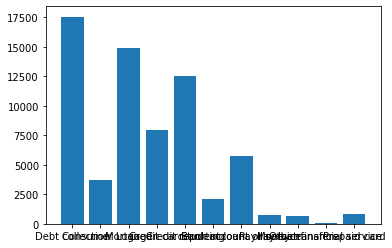

In [16]:
### As you can see the data is not clean, let's start preprocessing

### Drop nan values (1line)
df.dropna(inplace=True)
### Plot the classes that we have (column product) 

arr = df['product'].values
print(np.unique(arr))
counts = Counter(arr)
ww =  [ counts[k] for k in counts ]
plt.bar(counts.keys(),ww,width=0.8,)
counts

['Bank account or service' 'Consumer Loan' 'Credit card or prepaid card'
 'Credit reporting' 'Debt collection' 'Mortgage'
 'Payday loan, student loan']


Counter({'Debt collection': 17552,
         'Consumer Loan': 3678,
         'Mortgage': 14919,
         'Credit card or prepaid card': 8790,
         'Credit reporting': 12526,
         'Payday loan, student loan': 2854,
         'Bank account or service': 5711})

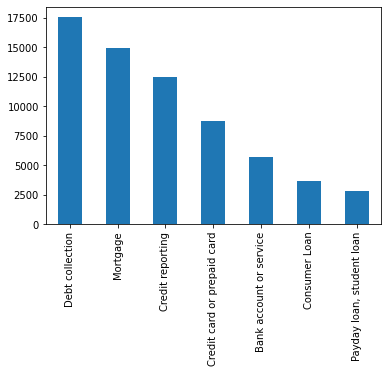

In [17]:
### Since our data is imbalanced we can group classes which seem similar together

df.loc[df['product'] == 'Payday loan', 'product'] = 'Payday loan, student loan'
df.loc[df['product'] == 'Student loan', 'product'] = 'Payday loan, student loan'
df.loc[df['product'] == 'Consumer loan', 'product'] = 'Payday loan, student loan'

df.loc[df['product'] == 'Credit card', 'product'] = 'Credit card or prepaid card'
df.loc[df['product'] == 'Prepaid card', 'product'] = 'Credit card or prepaid card'
df = df[df['product'] != "Other financial service"]
df = df[df['product'] != "Money transfers"]

arr = df['product'].values
def plot_df_classes(series):
    series.value_counts().plot.bar()# put code here (3 lines)

print(np.unique(arr))
counts = Counter(arr)
ww =  [ counts[k] for k in counts ]
plot_df_classes(df["product"])
counts

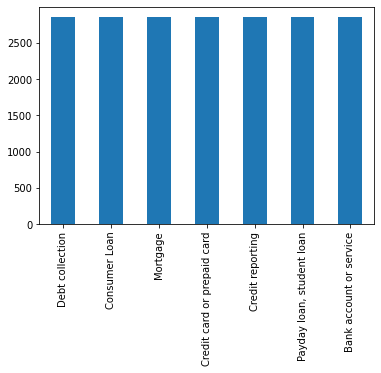

In [18]:
### Now we end up with 7 classes, let's keep only 2854 texts per class (for the sake of simplifying the lab)
## use df.sample(n) to keep n elements
nb_per_class = 2854
arr = df['product'].values
counts = Counter(arr)
new_data = pd.DataFrame()
for cls in counts:
    d = df[df["product"] == cls] 
    new_data = new_data.append(d.sample(n=nb_per_class))

def plot_df_classes(series):
    series.value_counts().plot.bar()# put code here (3 lines)

plot_df_classes(new_data["product"])

In [19]:
## convert labels to numbers 
classes = {"Bank account or service":0,"Consumer Loan":1,"Credit card or prepaid card":2,\
              "Credit reporting":3,'Debt collection':4,'Mortgage':5,\
                'Payday loan, student loan': 6 }
                
new_data = new_data.replace({"product": classes})


In [20]:
new_data

,product,consumer_complaint_narrative
511994,4,On XX/XX/XXXX I paid the original creditor dir...
497859,4,I have been paying a debt collector since XX/X...
288533,4,I have paid on a yamaha credit cart for 7 year...
514266,4,Penn Credit ( previous case XXXX ) is attempti...
210112,4,"I am in a position to settle this debt, but ag..."
...,...,...
286130,0,Chase Bank has notified us that any users of o...
286867,0,Good dayToday i found out my bank account is f...
516392,0,My checking account was defrauded on XXXX/XXXX...
499930,0,I was unaware that I am being Charged an inact...


In [21]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text =  REPLACE_BY_SPACE_RE.sub(' ',text)# replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub(' ',text)  # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    
    # Single character removal
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    TAG_RE = re.compile(r'<[^>]+>')
    text = TAG_RE.sub('', text)

    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
    
new_data['consumer_complaint_narrative'] = new_data['consumer_complaint_narrative'].apply(clean_text)

Tokenization

### Tokenization
![alt text](https://nlp.fast.ai/images/multifit_vocabularies.png)

There are three main types of NLP models:
1. Character Level
2. Word Level
3. Sentence Level


In [22]:
import nltk.tokenize as tokenization
import nltk
nltk.download('punkt')

sent_tokens = []
### task: tokenize all sentences in our corpus (2 lines)
# use tokenization.word_tokenize
for sent in  new_data['consumer_complaint_narrative'].values:
    sent_tokens.append(tokenization.word_tokenize(sent))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Prepare train and test data


In [23]:
### Step 1: split data 

X = sent_tokens
Y = new_data['product'].values 

#Split data into train and test 
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20,shuffle=True, random_state = 42)
print(len(Y_train),len(Y_test))


15982 3996


# Encoding

#### BAG OF WORDS
In BoW we construct a dictionary that contains set of all unique words from our text review dataset.The frequency of the word is counted here. if there are d unique words in our dictionary then for every sentence or review the vector will be of length d and count of word from review is stored at its particular location in vector. The vector will be highly sparse in such case.

![alt text](https://miro.medium.com/max/1134/1*lhH8dFbK5_saNe4kcWXwiA.png)


if we consider two reviews This pasta is very tasty and This pasta is not tasty after stopwords removal both sentences will be converted to pasta tasty so both giving exact same meaning.

#### N-Grams

Statistical language models, in its essence, are the type of models that assign probabilities to the sequences of words. 
You can think of an N-gram as the sequence of N words, by that notion, a 2-gram (or bigram) is a two-word sequence of words like “please turn”, “turn your”, or ”your homework”, and a 3-gram (or trigram) is a three-word sequence of words like “please turn your”, or “turn your homework”


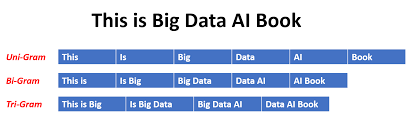

#### Word2Vec
Now we are considering the relationship between the words and trying to understand it by how many words are linked together or occur together frequently. 

There are two main architectures which yield the success of word2vec. The skip-gram and CBOW architectures.

How to obtain training samples ?

![alt text](https://miro.medium.com/max/536/1*vZhxrBkCz-yN_rzZBqSKiA.png)

![alt text](https://jaxenter.com/wp-content/uploads/2018/08/image-2.png)





In [24]:
### Step 2: Convert all words into numbers 
# to do this you can use keras Tokenizer, it's confusing with the other tokenizer from nltk
# the keras tokenizer converts each word into a number
all_words = np.concatenate(sent_tokens) # we concatenate all words from all sentences
## put code here (2 lines)
# call fit function
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(all_words)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


### Padding sequences
maxlen = 100
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)


Create dataloaders

In [25]:
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)


In [26]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 30
VOCAB_SIZE =  len(tokenizer.word_index) + 1

class lstm_model(torch.nn.Module) :
    def __init__(self, embedding_dim,hidden_dim ,vocab_size) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 7)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [27]:
model = lstm_model(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [28]:

def train(model,train_loader):
    for sentence, label in train_loader:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        
        #task: clear gradients 
        model.zero_grad()
        # Step 3. Run our forward pass.
        tag_scores = model(sentence)
        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, label)
        loss.backward()
        optimizer.step()

        
def test(model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    with torch.no_grad():
        for x, y in valid_dl:
            y_hat = model(x)
            loss = loss_function(y_hat, y)
            pred = torch.max(y_hat, 1)[1]
            total += y.shape[0]
            sum_loss += loss.item()*y.shape[0]
            ### Task: calculate accuracy

for epoch in range(20):  
    train(model,train_loader)
    test(model,test_loader)

